In [1]:
# Required libraries
import os
import math
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import nltk
from bs4 import BeautifulSoup

In [2]:
# Constants
my_data = "../data"

## Import data

Set of legacy questions to train/test the model. Query loads questions where last modification date was last year.

Stackexchange query is https://data.stackexchange.com/stackoverflow/query/edit/847084

select Id, Score, ViewCount, CreationDate, LastActivityDate, title, tags, body
from Posts 
where (score > 100) and (LastActivityDate > '2017-04-01') 
and (LastActivityDate < '2018-04-01') and (PostTypeId = 1)

In [3]:
# Load data into Pandas dataframe
datafile = "QueryResultsOld.csv"
full_path = os.path.join(my_data, datafile)
df_questions = pd.read_csv(full_path)
print(df_questions.shape)

(15089, 8)


Other set of questions to use with the trained model

https://data.stackexchange.com/stackoverflow/query/edit/846505

select Id, Score, ViewCount, CreationDate, LastActivityDate, title, tags, body
from Posts 
where (score > 100) and (LastActivityDate > '2018-04-01') and (PostTypeId = 1)

In [4]:
# Load data into Pandas dataframe
datafile = "QueryResultsNew.csv"
full_path = os.path.join(my_data, datafile)
df_new_questions = pd.read_csv(full_path)
print(df_new_questions.shape)

(3865, 8)


Have a quick look on the content of the uploaded data.

In [5]:
# sample structure and content
print(df_questions.columns)
print(df_questions.loc[5000])

Index(['Id', 'Score', 'ViewCount', 'CreationDate', 'LastActivityDate', 'title',
       'tags', 'body'],
      dtype='object')
Id                                                            3269717
Score                                                             109
ViewCount                                                       39788
CreationDate                                      2010-07-17 00:39:24
LastActivityDate                                  2018-03-28 15:17:03
title               Moq: How to get to a parameter passed to a met...
tags                                                        <c#><moq>
body                <p>Imagine this class</p>\n\n<pre><code>public...
Name: 5000, dtype: object


### Tokenize words

This piece of code cleans up the HTML content, removes stop words and converts the remaining ones into a list of stems.
The result is a new column in the table with that list for each question.

In [6]:
from nltk.stem import SnowballStemmer

# Take only aplanumeric words, no punctuation signs
tokenizer = nltk.RegexpTokenizer('\w+')

# Prepare set of stopwords
stopWords = set(stopwords.words('english'))

# Define stemmer
snowball_stemmer = SnowballStemmer("english")

wordsFiltered = []
wordsArray = []

for html_text in df_questions['body'] + " " + df_questions['title']:
    soup = BeautifulSoup(html_text, "lxml").get_text()
    words = tokenizer.tokenize(soup.lower())
    his_words = ''
    for w in words:
        if w not in stopWords:
            stem = snowball_stemmer.stem(w)
            wordsFiltered.append(stem)
            his_words = his_words + ' ' + stem
    wordsArray.append(his_words)


In [7]:
# Add a column to the dataframe with le list of cleaned stems
df_questions['words'] = wordsArray

In [8]:
# Quickly check the results
df_questions.loc[5000]

Id                                                            3269717
Score                                                             109
ViewCount                                                       39788
CreationDate                                      2010-07-17 00:39:24
LastActivityDate                                  2018-03-28 15:17:03
title               Moq: How to get to a parameter passed to a met...
tags                                                        <c#><moq>
body                <p>Imagine this class</p>\n\n<pre><code>public...
words                imagin class public class foo privat handler ...
Name: 5000, dtype: object

The variabe wordsFiltered is a list with all the stems as they appear. It has duplicate entries.

In [9]:
print("Total number of stems {0}".format(len(wordsFiltered)))

words_freq = nltk.FreqDist(wordsFiltered)

print("Total number of unique stems {0}".format(len(words_freq)))

Total number of stems 975465
Total number of unique stems 40992


In [10]:
wordsFiltered

['redirect',
 'https',
 'http',
 'opposit',
 'seem',
 'everyon',
 'teach',
 'server',
 'https',
 'paid',
 'ssl',
 'certif',
 'mirror',
 'keep',
 'around',
 'emerg',
 'merit',
 'get',
 'certif',
 'client',
 'desktop',
 'shortcut',
 'point',
 'http',
 'production_serv',
 'https',
 'production_serv',
 'work',
 'howev',
 'know',
 'product',
 'server',
 'goe',
 'dns',
 'forward',
 'kick',
 'client',
 'https',
 'shortcut',
 'stare',
 'https',
 'mirror_serv',
 'work',
 'big',
 'fat',
 'internet',
 'explor',
 '7',
 'red',
 'screen',
 'uneasy',
 'compani',
 'unfortun',
 'switch',
 'around',
 'client',
 'level',
 'user',
 'comput',
 'illiter',
 'like',
 'freak',
 'see',
 'https',
 'insecur',
 'error',
 'especi',
 'way',
 'firefox',
 '3',
 'internet',
 'explor',
 '7',
 'handl',
 'nowaday',
 'full',
 'stop',
 'kind',
 'thank',
 'help',
 'lol',
 'easi',
 'find',
 'apach',
 'solut',
 'http',
 'https',
 'redirect',
 'life',
 'opposit',
 'idea',
 'redirect',
 'https',
 'http',
 'time',
 'time',
 'see'

In [11]:
common_words = pd.DataFrame(words_freq.most_common(80))


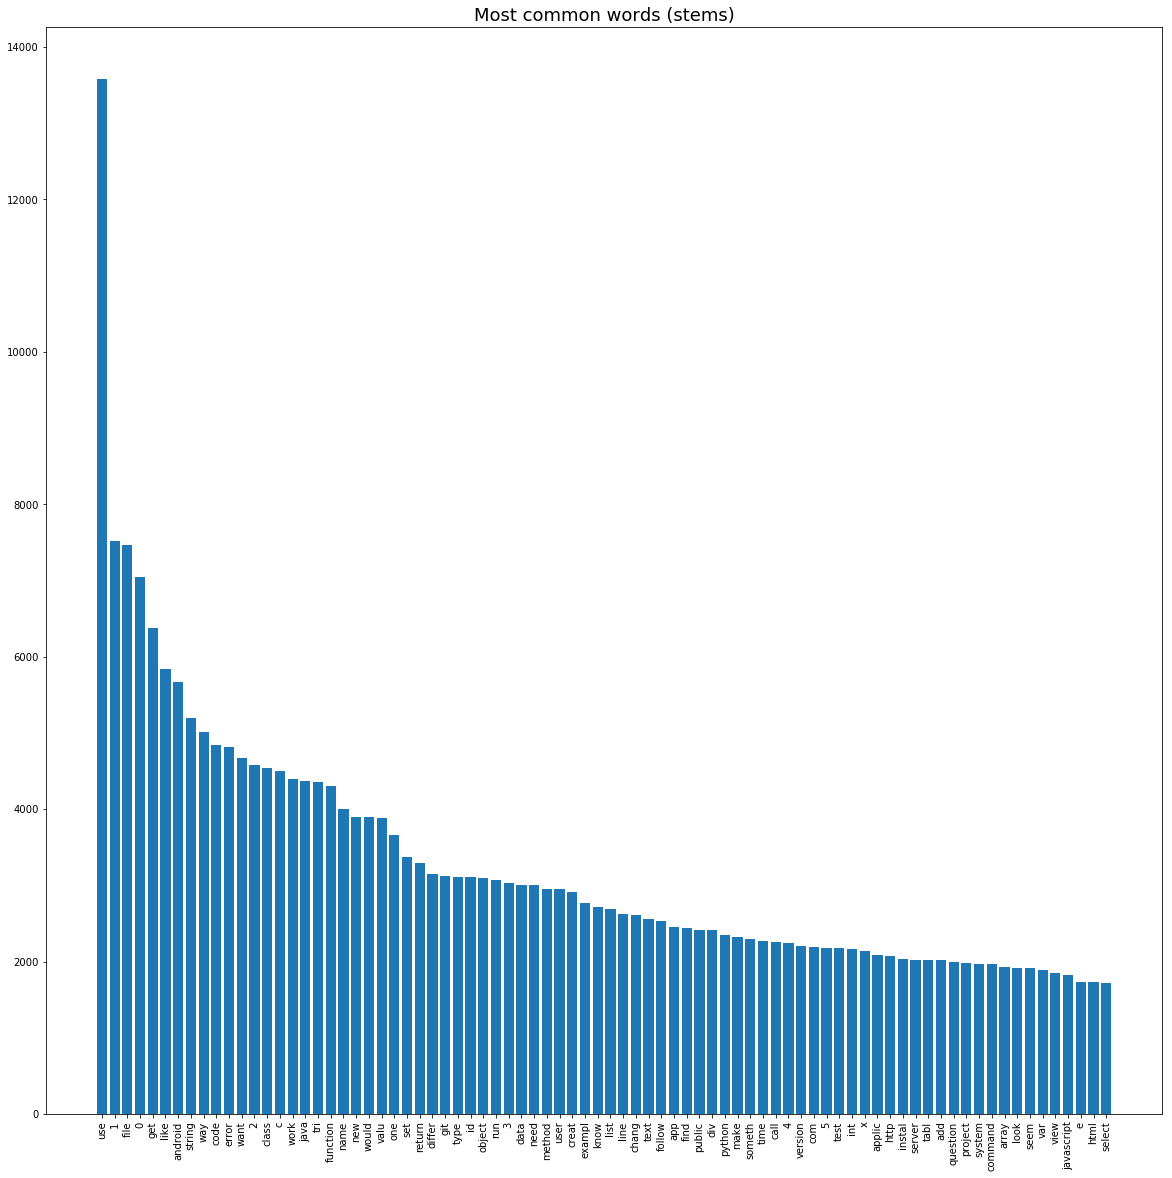

In [12]:
# Histogram of the most common words
fig, ax = plt.subplots(figsize=(20, 20))
indexes = np.arange(len(common_words[0]))
values = common_words[1]
labels = common_words[0]
plt.bar(indexes, values)
plt.xticks(indexes, labels, rotation='vertical')
plt.title('Most common words (stems)', fontsize=18)
plt.show()

### Vectorize stems

The set of stems gets vectorized. Each question is a line of the matrix and each stem is a column. The values are the number of occurrences of each stem in each question.
Any word that is used in more than 95% of the questions or less than 5 times across all questions is removed, because its either too common or too specific to be used for the topic determination.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
stem_vectorizer = CountVectorizer(lowercase = True, max_df=0.95, min_df=5)
stem_matrix = stem_vectorizer.fit_transform(df_questions['words'])

In [14]:
print("Remaining {1} stems for {0} questions".format(stem_matrix.shape[0], stem_matrix.shape[1]))

Remaining 5755 stems for 15089 questions


#### Statistics for number of remaining stems per question

In [15]:
print('Maximum number of stems per question: {0}'.format(stem_matrix.sum(1).max()))
print('Minimum number of stems per question: {0}'.format(stem_matrix.sum(1).min()))
print('Average number of stems per question: {0:.0f}'.format(stem_matrix.sum(1).mean()))
print('Average number of unique stems per question: {0:.0f}'.format(stem_matrix.getnnz(1).mean()))

Maximum number of stems per question: 2386
Minimum number of stems per question: 2
Average number of stems per question: 56
Average number of unique stems per question: 32


In [16]:
print(stem_matrix[15088])

  (0, 1666)	2
  (0, 1034)	2
  (0, 80)	1
  (0, 4320)	3
  (0, 180)	1
  (0, 42)	1
  (0, 4122)	11
  (0, 933)	1
  (0, 1794)	2
  (0, 2029)	1
  (0, 4831)	1
  (0, 1789)	8
  (0, 3869)	3
  (0, 73)	1
  (0, 2747)	1
  (0, 2423)	1
  (0, 1734)	2
  (0, 241)	1
  (0, 4297)	2
  (0, 4129)	3
  (0, 5352)	8
  (0, 1502)	1
  (0, 4082)	1
  (0, 4963)	3
  (0, 5172)	2
  :	:
  (0, 4128)	22
  (0, 5018)	9
  (0, 3735)	1
  (0, 4433)	2
  (0, 29)	3
  (0, 2165)	1
  (0, 3522)	1
  (0, 4215)	1
  (0, 2023)	1
  (0, 3168)	1
  (0, 4065)	3
  (0, 5234)	2
  (0, 2184)	17
  (0, 2760)	2
  (0, 4365)	1
  (0, 5422)	5
  (0, 3562)	3
  (0, 3721)	2
  (0, 2130)	2
  (0, 2596)	1
  (0, 2485)	1
  (0, 2208)	1
  (0, 1885)	2
  (0, 3946)	1
  (0, 2258)	1


In [17]:
print(stem_vectorizer.vocabulary_)

{'redirect': 4240, 'https': 2562, 'http': 2550, 'opposit': 3716, 'seem': 4544, 'everyon': 1913, 'teach': 5055, 'server': 4581, 'paid': 3788, 'ssl': 4826, 'certif': 1080, 'mirror': 3313, 'keep': 2924, 'around': 700, 'emerg': 1820, 'merit': 3270, 'get': 2258, 'client': 1170, 'desktop': 1579, 'shortcut': 4643, 'point': 3946, 'work': 5654, 'howev': 2539, 'know': 2953, 'product': 4047, 'goe': 2355, 'dns': 1676, 'forward': 2164, 'kick': 2946, 'big': 876, 'fat': 2012, 'internet': 2765, 'explor': 1961, 'red': 4235, 'screen': 4513, 'compani': 1249, 'unfortun': 5347, 'switch': 5005, 'level': 3042, 'user': 5424, 'comput': 1278, 'like': 3061, 'see': 4541, 'insecur': 2721, 'error': 1885, 'especi': 1894, 'way': 5570, 'firefox': 2089, 'handl': 2439, 'nowaday': 3580, 'full': 2208, 'stop': 4879, 'kind': 2949, 'thank': 5110, 'help': 2485, 'easi': 1759, 'find': 2076, 'apach': 635, 'solut': 4743, 'life': 3054, 'idea': 2596, 'time': 5154, 'enum': 1864, 'follow': 2130, 'flag': 2101, 'public': 4102, 'option'

Number of stems in the vectorized vocabulary

In [18]:
print('Number of stems in the vectorized vocabulary : {0}'.format(len(stem_vectorizer.vocabulary_)))

Number of stems in the vectorized vocabulary : 5755


### Vectorize tags

In [19]:
tag_vectorizer = CountVectorizer(lowercase = True, max_df=1.0, min_df=0, token_pattern = '[^<>]+')
tag_matrix = tag_vectorizer.fit_transform(df_questions['tags'])
print(tag_matrix.shape)

(15089, 5443)


In [20]:
tag_matrix.max()

1

In [21]:
tag_matrix.min()

0

In [22]:
print(tag_matrix)

  (0, 339)	1
  (0, 2270)	1
  (0, 3937)	1
  (0, 4486)	1
  (1, 700)	1
  (1, 1600)	1
  (1, 1791)	1
  (2, 700)	1
  (2, 1910)	1
  (2, 3714)	1
  (2, 4914)	1
  (3, 3)	1
  (3, 1585)	1
  (3, 2795)	1
  (4, 3124)	1
  (4, 4451)	1
  (4, 4892)	1
  (5, 700)	1
  (5, 2525)	1
  (6, 35)	1
  (6, 1573)	1
  (6, 2022)	1
  (6, 2372)	1
  (6, 3397)	1
  (7, 1127)	1
  :	:
  (15080, 8)	1
  (15080, 5173)	1
  (15081, 1240)	1
  (15081, 2548)	1
  (15081, 2599)	1
  (15081, 3054)	1
  (15082, 1127)	1
  (15082, 1798)	1
  (15083, 2548)	1
  (15083, 3240)	1
  (15084, 1144)	1
  (15084, 3495)	1
  (15084, 3823)	1
  (15085, 2525)	1
  (15085, 2528)	1
  (15085, 2535)	1
  (15085, 2699)	1
  (15086, 1415)	1
  (15087, 552)	1
  (15087, 1166)	1
  (15087, 2799)	1
  (15088, 2879)	1
  (15088, 3823)	1
  (15088, 3826)	1
  (15088, 4166)	1


Tag_matrix is composed only of ones (and zeroes but they are not physicall represented because it's a sparse matrix).

In [23]:
print('Total number of different tags: {0}'.format(tag_matrix.shape[1]))

Total number of different tags: 5443


In [24]:
print('Maximum number of tags per question: {0}'.format(tag_matrix.sum(1).max()))
print('Minimum number of tags per question: {0}'.format(tag_matrix.sum(1).min()))
print('Average number of tags per question: {0:.0f}'.format(tag_matrix.sum(1).mean()))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Average number of tags per question: 3


In [25]:
# Create a datraframe with the list of tags and the number of times they are used
tag_names = tag_vectorizer.get_feature_names()

tag_df = pd.DataFrame(tag_matrix.sum(0)).T
tag_df.rename(index=str, columns={0:'number'}, inplace=True)
tag_df['names'] = tag_names

In [26]:
tag_df

,number,names
0,2,.a
1,1,.bash-profile
2,18,.htaccess
3,543,.net
4,7,.net-2.0
5,13,.net-3.5
6,16,.net-4.0
7,6,.net-4.5
8,1,.net-4.5.2
9,4,.net-assembly


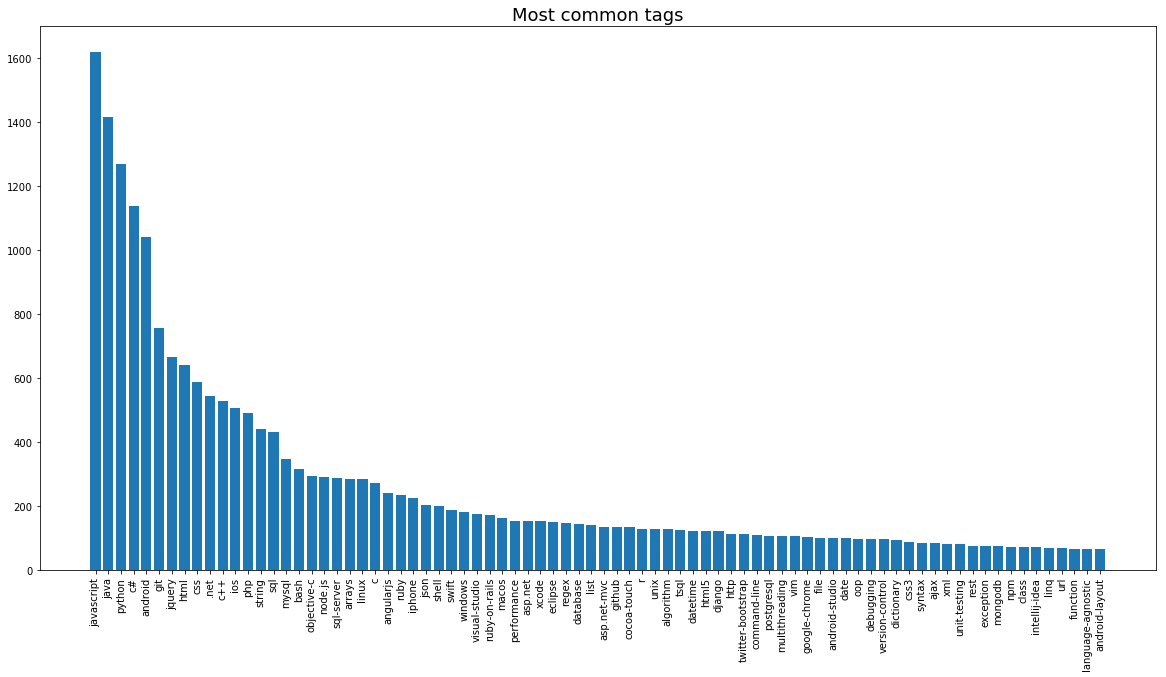

In [27]:
# Check tags distribution
fig, ax = plt.subplots(figsize=(20, 10))
top_tags = tag_df.sort_values(by='number', ascending=False).head(80)
indexes = np.arange(80)
values = top_tags['number']
labels = top_tags['names']
plt.bar(indexes, values)
plt.xticks(indexes, labels, rotation='vertical')
plt.title('Most common tags', fontsize=18)
plt.show()

In [28]:
tf_feature_names = stem_vectorizer.get_feature_names()

### Explore topic engineering with Latent Dirichlet Allocation.

Checking score and perplexity for variable number of topics

In [29]:
from sklearn.decomposition import LatentDirichletAllocation

for no_topics in np.arange(15, 15+1, 1):

    # Run LDA
    lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online',
                                    learning_offset=50.,random_state=0)

    lda_corpus = lda.fit_transform(stem_matrix)
    print(lda.score(stem_matrix))
    print("Perplexity for {0} topics {1}".format(no_topics, lda.perplexity(stem_matrix)))

-14735836.524
Perplexity for 15 topics 39634763.836576484


Observation : the perplexity strictly increases with the number of topics when tested between 2 and 90. It almost doubles with each additional topic. It's close to 1000*2^(ntopics-1).
The score doesn't change so much with the number of topics.

Another evaluation method is the rate of proposed tags that match with the real given ones.

In [30]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [31]:
n_top_words = 20
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: file git command use directori commit run chang project branch local work path want window folder line repositori tri script
Topic #1: python test line number print import self py modul def virtualenv get key return code str file function tri call
Topic #2: java class public method object new string static void return thread privat call except system null properti code use get
Topic #3: date 00 10 11 05 12 format 15 time 01 02 03 datetim 24 androidruntim 19 13 20 26 18
Topic #4: use differ code understand googl mean question map read vs oper implement data time one warn could applic compil know
Topic #5: div use control set class html work item id model tag element name scope like get properti content ng want
Topic #6: tabl column databas key sql select null queri data mysql row id valu insert creat name server updat set db
Topic #7: function var name js javascript json valu node php type foo npm option script data input get return jqueri text
Topic #8: android instal version

### Topic engineering using tf-idf

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
n_features = 2000
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_questions['words'])

In [33]:
from sklearn.decomposition import NMF
n_components = 20
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

In [34]:
nmf.components_.shape

(20, 2000)

In [35]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: use code like way app user work know applic want set need view question imag make time chang someth look
Topic #1: git branch commit repositori master remot push chang merg github repo local pull origin clone checkout head histori rebas delet
Topic #2: string charact convert replac str char remov return split length contain like way hello int format substr integ concaten check
Topic #3: file directori folder path txt open delet read filenam upload exist copi creat content project batch write want download jar
Topic #4: android id layout_width wrap_cont layout_height textview activ studio button app xml fill_par layout view com apk color applic sdk linearlayout
Topic #5: div element css id html width text height jqueri imag style content button class page center click li background span
Topic #6: tabl sql column mysql databas queri row select server data insert id null key creat exist constraint record foreign count
Topic #7: array element php numpi convert int way arr loop in

td-idf is not so well adapted for the objective we are pursuing : propose tags for only one document. In this case it's difficult to calculate the inverse document frequency for just one document. Let's go back to LDA.

The LDA corpus matrix gives the probability for a document to belong to a topic.

In [36]:
lda_corpus.T.shape

(15, 15089)

In [37]:
lda_corpus[11]

array([ 0.76762148,  0.00121212,  0.00121212,  0.00121213,  0.06463974,
        0.00121212,  0.00121212,  0.00121212,  0.00121212,  0.00121212,
        0.00121212,  0.00121212,  0.00121212,  0.00121212,  0.15319331])

Create a matrix that gives the weight of each tag for each topic. Weight can be grater than 1 if a tag is used several times in a topic.

In [38]:
topic_tag_weight = np.matmul(lda_corpus.T, tag_matrix.todense())

In [39]:
topic_tag_weight.shape

(15, 5443)

In [40]:
topic_tag_df = pd.DataFrame(topic_tag_weight)

In [41]:
topic_tag_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.360346,0.005877,0.136228,0.017937,0.323802,0.132463,0.005877,0.005877,0.156940,0.546537,0.005877,0.005877,0.005877,0.005877,0.284606
1,0.774778,0.003175,0.003175,0.053823,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.133304,0.003175,0.003175
2,3.305959,0.110874,0.143973,1.548626,1.802899,0.614979,0.168683,0.667523,0.073194,6.034315,0.045313,0.098468,1.034194,0.147181,2.203819
3,47.081153,14.999758,68.286772,10.353867,66.678389,34.753552,15.613343,16.631898,10.875836,51.297159,25.053981,5.139618,16.578488,36.013375,123.642813
4,0.245937,0.152014,0.912102,0.033407,0.366676,0.240519,0.207334,0.045691,0.011732,1.477926,0.614872,0.011732,0.145333,0.357769,2.176957
5,0.391900,0.375723,2.059578,0.312103,0.575657,0.847593,1.040572,0.441700,0.021032,1.031620,0.952494,0.041972,0.325713,0.692133,3.890210
6,2.756569,0.335134,1.935741,0.085508,2.523617,0.576447,0.159310,0.240637,1.096576,3.416644,0.448324,0.090966,0.040084,0.865574,1.428868
7,0.894478,0.055161,2.650998,0.013023,0.562095,0.271257,0.005491,0.096991,0.005491,0.401716,0.050452,0.027476,0.198977,0.226464,0.539931
8,0.441024,0.002899,0.002899,0.002899,0.002899,0.002899,0.048104,0.002899,0.109358,0.054632,0.002899,0.002899,0.002899,0.317896,0.002899
9,0.675848,0.307547,0.081027,0.020974,1.135922,0.064531,0.005100,0.324215,0.248599,0.829118,0.005100,0.006570,0.050681,0.121061,0.123706


In [42]:
topic_tag_df.shape[0]

15

In [43]:
# List of tags per topic
for topic in np.arange(topic_tag_df.shape[0]):
    print('------------ topic {0} ---------------'.format(topic))
    for i in topic_tag_df.iloc[topic].argsort()[:-10:-1]:
        print(tag_df.iloc[i]['names'])

------------ topic 0 ---------------
git
bash
linux
python
shell
c#
java
windows
github
------------ topic 1 ---------------
python
javascript
java
string
c#
dictionary
unit-testing
bash
python-3.x
------------ topic 2 ---------------
java
c#
.net
android
javascript
c++
python
multithreading
string
------------ topic 3 ---------------
datetime
python
javascript
date
java
sql
c#
php
android
------------ topic 4 ---------------
java
javascript
c#
python
c++
android
.net
c
php
------------ topic 5 ---------------
javascript
html
css
angularjs
jquery
c#
python
android
java
------------ topic 6 ---------------
sql
mysql
sql-server
database
tsql
postgresql
c#
python
javascript
------------ topic 7 ---------------
javascript
jquery
node.js
php
json
html
python
c#
angularjs
------------ topic 8 ---------------
android
java
eclipse
android-studio
macos
python
ios
xcode
android-layout
------------ topic 9 ---------------
c#
javascript
android
java
ios
php
python
.net
node.js
------------ topic 1

In [44]:
lda.components_.shape

(15, 5755)

In [45]:
print(lda.components_[0,])

[  0.06670215   0.12376283   0.06667266 ...,   0.0666702   19.02796293
   0.06667288]


In [46]:
print(tfidf_feature_names)

['00', '000', '0000', '000000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0px', '10', '100', '1000', '1024', '11', '12', '123', '127', '13', '14', '15', '16', '168', '17', '18', '19', '192', '1px', '20', '200', '2000', '2005', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '21', '22', '23', '24', '25', '255', '26', '27', '28', '29', '30', '300', '3000', '31', '32', '33', '34', '35', '36', '38', '39', '40', '404', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '500', '51', '52', '53', '54', '55', '56', '57', '58', '59', '5px', '60', '600', '64', '80', '8080', '90', '99', '__init__', '_post', '_server', 'abc', 'abil', 'abl', 'abort', 'absolut', 'abstract', 'accept', 'access', 'accomplish', 'accord', 'account', 'achiev', 'act', 'action', 'actionbar', 'activ', 'activerecord', 'activitythread', 'actual', 'ad', 'adapt', 'adb', 'add', 'addit', 'address', 'adjust', 'admin', 'administr', 'advanc', 'advantag', 'advic', 'affect', 'age', 'agent', 'ago', '

## Classify new questions

The new questions get vectorized with the same set of stems than the training set. If new terms/stems are included, they are just ignored.

In [47]:
newWordsFiltered = []
newWordsArray = []

for html_text in df_new_questions['body'] + " " + df_new_questions['title']:
    soup = BeautifulSoup(html_text, "lxml").get_text()
    words = tokenizer.tokenize(soup.lower())
    his_words = ''
    for w in words:
        if (w not in stopWords):
            stem = snowball_stemmer.stem(w)
            wordsFiltered.append(stem)
            his_words = his_words + ' ' + stem
    newWordsArray.append(his_words)

# Add a column to the dataframe with le list of cleaned stems
df_new_questions['words'] = newWordsArray
stem_matrix_new = stem_vectorizer.transform(df_new_questions['words'])

In [48]:
df_new_questions.shape

(3865, 9)

In [49]:
df_new_questions

,Id,Score,ViewCount,CreationDate,LastActivityDate,title,tags,body,words
0,8692,190,213093,2008-08-12 11:28:36,2018-04-17 11:32:54,How to use Xpath in Python?,<python><xml><dom><xpath><nodes>,<p>What is the library? Is there a full implem...,librari full implement librari use websit use...
1,10752,250,42186,2008-08-14 06:27:57,2018-04-16 20:15:33,What is the difference between integration and...,<unit-testing><integration-testing>,<p>I know the so-called textbook definition of...,know call textbook definit unit test integr t...
2,24816,537,560391,2008-08-24 02:52:42,2018-04-20 17:56:57,Escaping HTML strings with jQuery,<javascript><jquery><string><escaping>,<p>Does anyone know of an easy way to escape H...,anyon know easi way escap html string jqueri ...
3,24678,129,96714,2008-08-23 22:42:50,2018-04-05 06:40:55,JavaScript editor within Eclipse,<javascript><eclipse><plugins><editor>,<p>I'm looking for the best JavaScript editor ...,look best javascript editor avail eclips plug...
4,25259,230,32374,2008-08-24 18:21:11,2018-04-18 21:39:01,How does Stack Overflow generate its SEO-frien...,<regex><language-agnostic><seo><friendly-url><...,"<p>What is a good complete <a href=""http://en....",good complet regular express process would ta...
5,1720320,224,207375,2009-11-12 06:35:27,2018-04-03 10:04:20,How to dynamically create CSS class in JavaScr...,<javascript><css><stylesheet>,<p>I need to create a CSS stylesheet class dyn...,need creat css stylesheet class dynam javascr...
6,1720421,1543,1274493,2009-11-12 07:04:09,2018-04-19 15:17:45,How to concatenate two lists in Python?,<python><list>,<p>How do I concatenate two lists in Python?</...,concaten two list python exampl liston 1 2 3 ...
7,26141731,134,107621,2014-10-01 12:45:56,2018-04-16 16:05:56,Launch Image does not show up in my iOS App,<ios8><xcode6><xcasset><launchimage>,<p>I want to get a simple launch screen to sho...,want get simpl launch screen show app built u...
8,9950144,117,33848,2012-03-30 20:40:07,2018-04-11 19:38:00,Access lapply index names inside FUN,<r><lapply><names><indices>,<p>Is there a way to get the list index name i...,way get list index name lappli function n nam...
9,26143315,142,72537,2014-10-01 14:05:55,2018-04-23 06:17:13,Laravel 5 - artisan seed [ReflectionException]...,<laravel><composer-php><laravel-5><artisan>,<p>When I run <strong>php artisan db:seed</str...,run php artisan db seed get follow error refl...


In [50]:
print(stem_matrix_new)

  (0, 2208)	1
  (0, 2646)	1
  (0, 3051)	2
  (0, 4128)	1
  (0, 5422)	2
  (0, 5588)	1
  (0, 5712)	1
  (1, 460)	1
  (1, 491)	2
  (1, 579)	1
  (1, 623)	2
  (1, 845)	1
  (1, 848)	1
  (1, 871)	1
  (1, 891)	1
  (1, 1016)	1
  (1, 1149)	7
  (1, 1162)	1
  (1, 1201)	1
  (1, 1374)	1
  (1, 1432)	1
  (1, 1542)	2
  (1, 1614)	2
  (1, 1773)	1
  (1, 1895)	1
  :	:
  (3863, 5649)	1
  (3864, 448)	1
  (3864, 629)	1
  (3864, 744)	3
  (3864, 990)	1
  (3864, 1094)	2
  (3864, 1345)	1
  (3864, 1533)	1
  (3864, 2051)	1
  (3864, 2165)	1
  (3864, 2214)	1
  (3864, 2675)	4
  (3864, 2737)	1
  (3864, 3338)	3
  (3864, 3996)	1
  (3864, 4515)	1
  (3864, 4544)	1
  (3864, 4775)	1
  (3864, 4937)	2
  (3864, 5005)	1
  (3864, 5023)	1
  (3864, 5089)	2
  (3864, 5125)	1
  (3864, 5422)	1
  (3864, 5734)	1


In [51]:
stem_matrix_new.shape

(3865, 5755)

In [52]:
stem_matrix.shape

(15089, 5755)

In [53]:
lda_new_corpus = lda.transform(stem_matrix_new)

In [193]:
lda_new_corpus[1500]

array([ 0.28774511,  0.30470731,  0.00044445,  0.00044445,  0.1926075 ,
        0.02976383,  0.00044444,  0.00044445,  0.1254009 ,  0.00044445,
        0.00044444,  0.00044444,  0.00044445,  0.05577533,  0.00044445])

In [55]:
print(lda_new_corpus.shape)
print(topic_tag_weight.shape)

(3865, 15)
(15, 5443)


In [56]:
# Calculate matrix of tags probability per new question
new_questions_tags = lda_new_corpus.dot(topic_tag_weight)

In [57]:
new_questions_tags.shape

(3865, 5443)

In [58]:
new_questions_df = pd.DataFrame(new_questions_tags)

In [59]:
for question in np.arange(2000, 2010):
    print('---------------------------')
    print(df_new_questions.iloc[question][['title','body','tags']])
    proposed_tags = ''
    for i in new_questions_df.iloc[question].argsort()[:-10:-1]:
        proposed_tags += (tag_df.iloc[i]['names']) + " "
    print(proposed_tags)

---------------------------
title    Simplest way to serve static data from outside...
body     <p>I have a Java web application running on To...
tags           <tomcat><java-ee><servlets><static-content>
Name: 2000, dtype: object
javascript java c# git python android jquery ios .net 
---------------------------
title      How to install Python MySQLdb module using pip?
body     <p>How can I install the <a href="http://mysql...
tags                                  <python><mysql><pip>
Name: 2001, dtype: object
python android java javascript c# ios eclipse string macos 
---------------------------
title                              Java OCR implementation
body     <p>This is primarily just curiosity, but are t...
tags                                           <java><ocr>
Name: 2002, dtype: object
java c# python javascript c++ android .net string php 
---------------------------
title              Dependency Injection vs Factory Pattern
body     <p>Most of the examples quoted for usage 

In [60]:
# Matrice de probabilité d'appartenance d'une ancienne question à un topic
topic_proba_old = stem_matrix.dot(lda.components_.T)

In [61]:
topic_proba_old.shape

(15089, 15)

In [194]:
lda_corpus.shape

(15089, 15)

In [203]:
lda_corpus[10000]

array([ 0.13833329,  0.00099503,  0.14489031,  0.00099503,  0.00099503,
        0.18880767,  0.00099503,  0.00099503,  0.07151893,  0.01925517,
        0.00099503,  0.00099503,  0.00099503,  0.04102728,  0.38820713])

In [202]:
question_topic.loc[10000]

0     0.180169
1     0.024646
2     0.104174
3     0.005760
4     0.033080
5     0.102396
6     0.018450
7     0.061113
8     0.033158
9     0.053180
10    0.021724
11    0.002305
12    0.045110
13    0.003748
14    0.310986
Name: 10000, dtype: float64

In [62]:
question_topic = pd.DataFrame(topic_proba_old.T / (topic_proba_old.sum(axis = 1))).T

In [63]:
question_topic.shape

(15089, 15)

In [64]:
pd.DataFrame(topic_proba_old).sum(axis=1)

0         82314.269156
1         31962.856526
2        196666.102288
3         60722.465129
4         75620.047096
5         75955.991492
6         24273.314866
7         25757.790906
8        102784.498206
9         23473.554412
10        14798.608646
11       104238.219108
12        67217.656682
13        61895.695924
14        54234.621665
15        62854.145878
16        62841.075367
17        32479.536180
18        35107.378267
19        84991.220507
20        10930.522089
21        39535.766457
22        40625.011465
23       158924.126567
24        55786.353914
25        97682.651175
26        38408.279385
27        98961.725309
28       111439.317001
29        35572.093187
             ...      
15059     89111.415938
15060     80139.976924
15061     77367.427382
15062    359522.377676
15063    114612.830905
15064    100227.168329
15065    106014.462638
15066     60149.540701
15067    131759.471791
15068    156147.945487
15069    125191.279044
15070     74988.769584
15071     2

In [65]:
question_topic.sum(axis=1)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0
7        1.0
8        1.0
9        1.0
10       1.0
11       1.0
12       1.0
13       1.0
14       1.0
15       1.0
16       1.0
17       1.0
18       1.0
19       1.0
20       1.0
21       1.0
22       1.0
23       1.0
24       1.0
25       1.0
26       1.0
27       1.0
28       1.0
29       1.0
        ... 
15059    1.0
15060    1.0
15061    1.0
15062    1.0
15063    1.0
15064    1.0
15065    1.0
15066    1.0
15067    1.0
15068    1.0
15069    1.0
15070    1.0
15071    1.0
15072    1.0
15073    1.0
15074    1.0
15075    1.0
15076    1.0
15077    1.0
15078    1.0
15079    1.0
15080    1.0
15081    1.0
15082    1.0
15083    1.0
15084    1.0
15085    1.0
15086    1.0
15087    1.0
15088    1.0
dtype: float64

In [66]:
question_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.094458,0.018828,0.018402,0.009597,0.096712,0.089254,0.028535,0.045494,0.082646,0.279946,0.005578,0.003921,0.052397,0.003349,0.170883
1,0.070466,0.017463,0.121651,0.040778,0.179980,0.102725,0.015746,0.059270,0.012891,0.070031,0.014202,0.003648,0.036522,0.001742,0.252885
2,0.061770,0.016079,0.213179,0.004566,0.049690,0.121785,0.046124,0.097754,0.005666,0.041537,0.052376,0.004852,0.056512,0.002419,0.225692
3,0.077618,0.012026,0.035831,0.000728,0.183169,0.078863,0.082881,0.024358,0.012913,0.071474,0.010007,0.005096,0.036450,0.162259,0.206328
4,0.120489,0.011437,0.033355,0.000980,0.171629,0.071355,0.145041,0.022356,0.045683,0.130629,0.011116,0.003556,0.035800,0.043859,0.152715
5,0.047321,0.003188,0.520798,0.000276,0.030248,0.082560,0.016608,0.013332,0.014256,0.018489,0.081427,0.004912,0.051229,0.002400,0.112956
6,0.083053,0.002013,0.052250,0.000754,0.358254,0.081700,0.024283,0.009474,0.049259,0.064099,0.002797,0.000371,0.058129,0.022075,0.191489
7,0.071415,0.024988,0.008364,0.000237,0.040464,0.155273,0.007112,0.010842,0.043729,0.055130,0.040793,0.119567,0.110705,0.083763,0.227619
8,0.115251,0.017346,0.109603,0.007261,0.147965,0.072197,0.018629,0.037599,0.067641,0.149790,0.013077,0.003045,0.041694,0.014048,0.184855
9,0.307348,0.257722,0.001098,0.012343,0.001116,0.026076,0.001081,0.097895,0.019537,0.002269,0.029081,0.108652,0.033352,0.010956,0.091473


In [67]:
df_questions.join(question_topic)

,Id,Score,ViewCount,CreationDate,LastActivityDate,title,tags,body,words,0,...,5,6,7,8,9,10,11,12,13,14
0,8371,139,309981,2008-08-12 00:36:32,2018-01-24 17:07:30,How do you redirect HTTPS to HTTP?,<apache><ssl><redirect><https>,<p>How do you redirect HTTPS to HTTP?. That is...,redirect https http opposit seem everyon teac...,0.094458,...,0.089254,0.028535,0.045494,0.082646,0.279946,0.005578,0.003921,0.052397,0.003349,0.170883
1,8447,1076,352603,2008-08-12 04:09:16,2017-07-20 11:09:19,What does the [Flags] Enum Attribute mean in C#?,<c#><enums><flags>,<p>From time to time I see an enum like the fo...,time time see enum like follow flag public en...,0.070466,...,0.102725,0.015746,0.059270,0.012891,0.070031,0.014202,0.003648,0.036522,0.001742,0.252885
2,8625,187,98048,2008-08-12 09:13:23,2017-08-07 21:26:54,Generic type conversion FROM string,<c#><generics><primitive><type-safety>,<p>I have a class that I want to use to store ...,class want use store properti anoth class pro...,0.061770,...,0.121785,0.046124,0.097754,0.005666,0.041537,0.052376,0.004852,0.056512,0.002419,0.225692
3,8676,742,238017,2008-08-12 11:04:11,2018-01-28 08:46:28,Entity Framework vs LINQ to SQL,<.net><entity-framework><linq-to-sql>,<p>Now that .NET v3.5 SP1 has been released (a...,net v3 5 sp1 releas along vs2008 sp1 access n...,0.077618,...,0.078863,0.082881,0.024358,0.012913,0.071474,0.010007,0.005096,0.036450,0.162259,0.206328
4,10616,130,303035,2008-08-14 03:13:26,2018-03-23 06:47:26,Differences between MySQL and SQL Server,<mysql><sql-server><tsql>,"<p>I'm an <a href=""http://en.wikipedia.org/wik...",asp net develop use microsoft sql server data...,0.120489,...,0.071355,0.145041,0.022356,0.045683,0.130629,0.011116,0.003556,0.035800,0.043859,0.152715
5,24551,319,105271,2008-08-23 19:59:42,2017-10-20 21:05:40,Initialize class fields in constructor or at d...,<c#><java>,<p>I've been programming in C# and Java recent...,program c java recent curious best place init...,0.047321,...,0.082560,0.016608,0.013332,0.014256,0.018489,0.081427,0.004912,0.051229,0.002400,0.112956
6,24626,145,119015,2008-08-23 21:41:49,2018-03-12 10:27:11,Abstraction VS Information Hiding VS Encapsula...,<encapsulation><abstraction><glossary><ooad><i...,<p>Can you tell me what is the difference betw...,tell differ abstract inform hide softwar deve...,0.083053,...,0.081700,0.024283,0.009474,0.049259,0.064099,0.002797,0.000371,0.058129,0.022075,0.191489
7,25238,148,233326,2008-08-24 17:59:04,2017-08-23 03:10:17,100% Min Height CSS layout,<html><css><xhtml>,<p>What's the best way to make an element of 1...,best way make element 100 minimum height acro...,0.071415,...,0.155273,0.007112,0.010842,0.043729,0.055130,0.040793,0.119567,0.110705,0.083763,0.227619
8,25552,210,195232,2008-08-25 01:49:55,2017-09-27 19:24:20,get OS-level system information,<java><memory><resources><system>,<p>I'm currently building a Java app that coul...,current build java app could end run mani dif...,0.115251,...,0.072197,0.018629,0.037599,0.067641,0.149790,0.013077,0.003045,0.041694,0.014048,0.184855
9,25665,337,236927,2008-08-25 04:44:06,2017-10-03 08:42:29,Python module for converting PDF to text,<python><pdf><text-extraction><pdf-scraping>,<p>Which are the best Python modules to conver...,best python modul convert pdf file text pytho...,0.307348,...,0.026076,0.001081,0.097895,0.019537,0.002269,0.029081,0.108652,0.033352,0.010956,0.091473


In [68]:
print(tag_matrix[0].indices)

[ 339 2270 3937 4486]


In [69]:
type(tag_matrix[0])

scipy.sparse.csr.csr_matrix

In [70]:
tag_df[tag_df['names']=='ssl']

,number,names
4486,38,ssl


In [71]:
for name in tag_df.iloc[tag_matrix[1].indices]['names']:
    print(name)

c#
enums
flags


In [72]:
# Create matrix of tags for new questions
tag_matrix_new = tag_vectorizer.fit_transform(df_new_questions['tags'])
print(tag_matrix_new.shape)

(3865, 2616)


In [73]:
tag_df_new_questions = pd.DataFrame(tag_matrix_new.sum(0)).T
tag_df_new_questions.rename(index=str, columns={0:'number'}, inplace=True)
tag_names_new = tag_vectorizer.get_feature_names()
tag_df_new_questions['names'] = tag_names_new

In [74]:
df_new_questions['tags'].head(10)

0                     <python><xml><dom><xpath><nodes>
1                  <unit-testing><integration-testing>
2               <javascript><jquery><string><escaping>
3               <javascript><eclipse><plugins><editor>
4    <regex><language-agnostic><seo><friendly-url><...
5                        <javascript><css><stylesheet>
6                                       <python><list>
7                 <ios8><xcode6><xcasset><launchimage>
8                          <r><lapply><names><indices>
9          <laravel><composer-php><laravel-5><artisan>
Name: tags, dtype: object

In [75]:
for name in tag_df_new_questions.iloc[tag_matrix_new[1].indices]['names']:
    print(name)

integration-testing
unit-testing


In [76]:
new_questions_tags[0]

matrix([[ 0.18405446,  0.031433  ,  1.0872723 , ...,  0.12627915,
          0.03010033,  0.29995311]])

In [77]:
for question in np.arange(10, 20):
    print('---------------------------')
    print(df_new_questions.iloc[question][['title','body','tags']])
    tag_array = tag_df_new_questions.iloc[tag_matrix_new[question].indices]['names'].values
    print(tag_array)
    proposed_tags = ''
    right_tags = 0
    for i in new_questions_df.iloc[question].argsort()[:-10-1:-1]:
        proposed_tag = tag_df.iloc[i]['names']
        proposed_tags += (proposed_tag) + " "
        if proposed_tag in tag_array:
            right_tags += 1
    print(proposed_tags)
    print(right_tags/len(tag_array))

---------------------------
title    Formatting a number with exactly two decimals ...
body     <p>I have this line of code which rounds my nu...
tags                 <javascript><rounding><decimal-point>
Name: 10, dtype: object
['decimal-point' 'rounding' 'javascript']
python javascript java c# string c++ .net php android arrays 
0.3333333333333333
---------------------------
title    Generating a drop down list of timezones with PHP
body     <p>Most sites need some way to show the dates ...
tags                                  <php><timezone><utc>
Name: 11, dtype: object
['utc' 'timezone' 'php']
javascript jquery python java c# php node.js html json string 
0.3333333333333333
---------------------------
title    file_get_contents(): SSL operation failed with...
body     <p>I’ve been trying to access this particular ...
tags                   <php><rest><ssl><file-get-contents>
Name: 12, dtype: object
['file-get-contents' 'ssl' 'rest' 'php']
javascript java python c# android jquery i

In [183]:
for question in np.arange(0, len(df_new_questions)):
    tag_array = tag_df_new_questions.iloc[tag_matrix_new[question].indices]['names'].values
    proposed_tags = ''
    right_tags = 0
    for i in new_questions_df.iloc[question].argsort()[:-5-1:-1]:
        proposed_tag = tag_df.iloc[i]['names']
        proposed_tags += (proposed_tag) + " "
        if proposed_tag in tag_array:
            right_tags += 1
    df_new_questions.loc[question,'right'] = (right_tags/len(tag_array))
    df_new_questions.loc[question,'proposed_tags'] = proposed_tags

In [184]:
df_new_questions.loc[10]

Id                                                                    1726630
Score                                                                     495
ViewCount                                                              549055
CreationDate                                              2009-11-13 01:46:18
LastActivityDate                                          2018-04-25 05:08:45
title                       Formatting a number with exactly two decimals ...
tags                                    <javascript><rounding><decimal-point>
body                        <p>I have this line of code which rounds my nu...
words                        line code round number two decim place get nu...
right                                                                0.333333
proposed_tags                               python javascript java c# string 
right_supervised                                                     0.666667
proposed_tags_supervised                    rounding javascript 

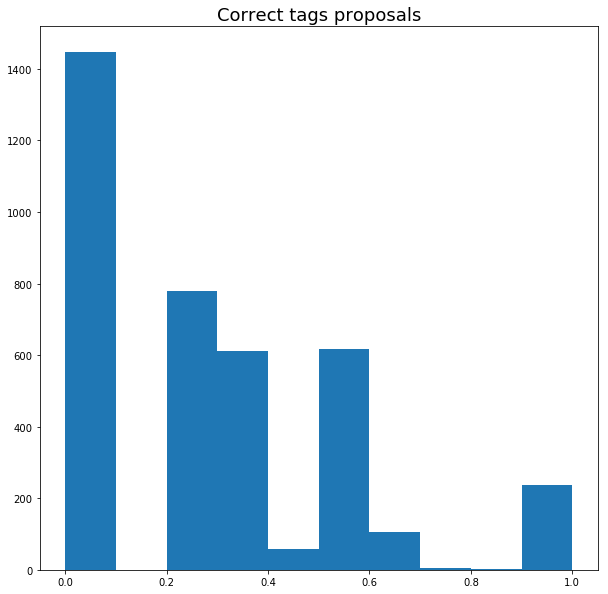

In [185]:
# Display distribution of correct ratio
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(df_new_questions['right'].dropna(), bins=10)
plt.title('Correct tags proposals', fontsize=18)
plt.show()

In [186]:
# Calculate the number of questions for which at least 50% of the tags were proposed
df_new_questions[df_new_questions['right'] >= 0.5]['Id'].count() / len(df_new_questions)

0.25071151358344113

## Supervised methodology

In this approach, a multi-label SVC is used to get the probability for each question to have a given tag.<br>Features are the stem matriw per question.<br>Labels are the tags.

In [136]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

X = stem_matrix
Y = tag_matrix

MultiLabelClassif = OneVsRestClassifier(SVC(kernel='linear', probability=True))
MultiLabelClassif.fit(X, Y)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [86]:
X_new = stem_matrix_new
new_predict = MultiLabelClassif.predict(X_new)

In [137]:
new_predict_proba = MultiLabelClassif.predict_proba(X_new)

In [138]:
for values in new_predict_proba[11]:
    print (values)

1.00000009947e-07
1.00000009947e-07
1.00000009947e-07
1.00000009947e-07
0.00129871885108
2.09108712295e-05
1.00000009947e-07
1.00000009947e-07
2.56026695409e-05
1.00000009947e-07
1.00000009947e-07
1.00000009947e-07
2.36975939888e-06
1.70340315447e-07
0.00223701443868
1.0466716493e-06
6.10677569847e-07
0.267428414577
1.42656952644e-06
1.00000009947e-07
1.00000009947e-07
1.00000009947e-07
1.00000009947e-07
5.31959177009e-06
2.83841009549e-07
0.0012904195295
1.00000009947e-07
0.00759834343269
7.77774071329e-06
1.00000009947e-07
1.00000009947e-07
5.61056627637e-07
6.27821887174e-07
0.00691163164658
5.026778724e-06
1.00000009947e-07
1.28436625955e-07
1.00000009947e-07
1.00000009947e-07
0.0036518692582
7.55323816316e-06
6.70397721127e-07
1.00000009947e-07
3.71244419468e-06
6.65609155292e-07
1.00000009947e-07
7.37460922943e-07
1.00000009947e-07
1.00000009947e-07
1.00000009947e-07
1.00000009947e-07
3.50045255401e-05
7.76750391651e-05
1.00000009947e-07
0.000330087656814
2.88658297764e-06
5.9929

In [129]:
import scipy
from scipy.sparse import csr_matrix, find
scipy.sparse.find(mew_predict[5])[1]

array([1127, 2211, 2548])

In [152]:
(new_predict_proba[10].argsort()[:-10-1:-1])

array([4066, 2548,  700, 2926, 2525,    3, 3349, 2211, 2479, 4438], dtype=int64)

In [153]:
for question in np.arange(10, 20):
    print('---------------------------')
    print(df_new_questions.iloc[question][['title','body','tags']])
    tag_array = tag_df_new_questions.iloc[tag_matrix_new[question].indices]['names'].values
    print(tag_array)
    proposed_tags = ''
    right_tags = 0
    for i in new_predict_proba[question].argsort()[:-10-1:-1]:
        proposed_tag = tag_df.iloc[i]['names']
        proposed_tags += (proposed_tag) + " "
        if proposed_tag in tag_array:
            right_tags += 1
    print(proposed_tags)
    print(right_tags/len(tag_array))

---------------------------
title    Formatting a number with exactly two decimals ...
body     <p>I have this line of code which rounds my nu...
tags                 <javascript><rounding><decimal-point>
Name: 10, dtype: object
['decimal-point' 'rounding' 'javascript']
rounding javascript c# math java .net objective-c html iphone sql 
0.6666666666666666
---------------------------
title    Generating a drop down list of timezones with PHP
body     <p>Most sites need some way to show the dates ...
tags                                  <php><timezone><utc>
Name: 11, dtype: object
['utc' 'timezone' 'php']
visual-studio-2013 encryption rspec2 insert html-select optional jstl tortoisegit tfvc nullable 
0.0
---------------------------
title    file_get_contents(): SSL operation failed with...
body     <p>I’ve been trying to access this particular ...
tags                   <php><rest><ssl><file-get-contents>
Name: 12, dtype: object
['file-get-contents' 'ssl' 'rest' 'php']
php rest variables

In [189]:
for question in np.arange(0, len(df_new_questions)):
    tag_array = tag_df_new_questions.iloc[tag_matrix_new[question].indices]['names'].values
    proposed_tags = ''
    right_tags = 0
    for i in new_predict_proba[question].argsort()[:-10-1:-1]:
        proposed_tag = tag_df.iloc[i]['names']
        proposed_tags += (proposed_tag) + " "
        if proposed_tag in tag_array:
            right_tags += 1
    df_new_questions.loc[question,'right_supervised'] = (right_tags/len(tag_array))
    df_new_questions.loc[question,'proposed_tags_supervised'] = proposed_tags

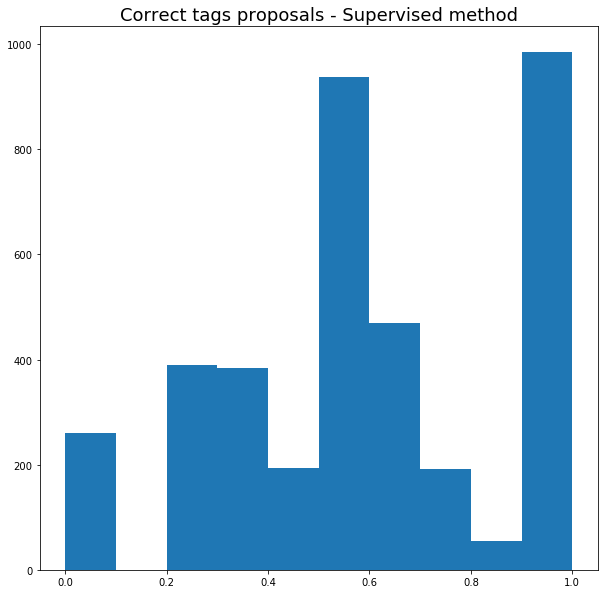

In [190]:
# Display distribution of correct ratio
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(df_new_questions['right_supervised'].dropna(), bins=10)
plt.title('Correct tags proposals - Supervised method', fontsize=18)
plt.show()

In [191]:
# Calculate the number of questions for which at least 50% of the tags were proposed
df_new_questions[df_new_questions['right_supervised'] >= 0.5]['Id'].count() / len(df_new_questions)

0.68227684346701167